# Telecom Customer Churn Prediction

This notebook predicts whether a telecom customer will churn using Decision Tree and Random Forest classifiers, with evaluation via confusion matrix, accuracy, and F1-score. An optional SVM model is included for comparison.

- Data preprocessing: imputation, scaling, one-hot encoding via ColumnTransformer + Pipelines
- Models: Decision Tree, Random Forest, optional SVM
- Metrics: confusion matrix, accuracy, F1-score (macro), classification report
- Outputs: metrics table, confusion matrix plots, persisted models (`models/`)

Instructions:
1. Place dataset CSV at `data/telecom_churn.csv` (update path below if needed)
2. Set the `TARGET_COLUMN` if your dataset uses a different name (default: `Churn`)
3. Run cells top-to-bottom



In [2]:
# Imports & setup
import os
import warnings
from typing import Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)



In [3]:
# Config & data loading (use your local dataset)
# We will resolve the dataset path by checking current dir, then models/, then data/
DATA_FILENAME = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'  # your dataset name
SHEET_NAME = None  # only used if you switch to Excel
CANDIDATE_TARGET_COLUMNS = ['Churn', 'churn', 'Exited', 'Customer_Churn']
TARGET_COLUMN = None  # auto-detect if None

# Ensure folders exist for outputs
os.makedirs('models', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)

# Resolve dataset path
candidate_paths = [
    DATA_FILENAME,
    os.path.join('models', DATA_FILENAME),
    os.path.join('model', DATA_FILENAME),
    os.path.join('data', DATA_FILENAME)
]
DATA_PATH = None
for p in candidate_paths:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        f"Dataset not found. Looked for {DATA_FILENAME} in: ./, models/, model/, data/. "
        f"Please place the file accordingly.")

# Load based on extension
_ext = os.path.splitext(DATA_PATH)[1].lower()
if _ext in ['.xlsx', '.xls']:
    raw_df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
else:
    raw_df = pd.read_csv(DATA_PATH)

print(f"Loaded from: {DATA_PATH} | shape: {raw_df.shape}")
raw_df.head()



Loaded from: WA_Fn-UseC_-Telco-Customer-Churn.csv | shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Basic inspection
print(raw_df.info())
print('\nNull counts:')
print(raw_df.isna().sum().sort_values(ascending=False).head(20))

# Auto-detect target if not set
if TARGET_COLUMN is None:
    for col in CANDIDATE_TARGET_COLUMNS:
        if col in raw_df.columns:
            TARGET_COLUMN = col
            break

if TARGET_COLUMN is None:
    raise ValueError('Could not auto-detect target column. Please set TARGET_COLUMN manually.')

print(f"Using target column: {TARGET_COLUMN}")

# Standardize target to binary 0/1 where possible
y_raw = raw_df[TARGET_COLUMN]
if y_raw.dtype == 'O':
    y = y_raw.astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0, 'true': 1, 'false': 0, '1': 1, '0': 0})
    if y.isna().any():
        # Fallback: if object but different labels, try factorize, set positive = max label
        y, uniques = pd.factorize(y_raw)
        # Map to 0/1 if binary
        if len(uniques) == 2:
            # keep as 0/1 from factorize
            y = pd.Series(y, index=y_raw.index)
        else:
            raise ValueError(f'Target has {len(uniques)} classes; expected binary churn label. Uniques: {list(uniques)}')
else:
    # numeric target assumed already 0/1
    y = y_raw.astype(int)

X = raw_df.drop(columns=[TARGET_COLUMN])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Preprocessing: identify numeric/categorical, build transformers
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")



Numeric features: 3 | Categorical features: 17
Train: (5634, 20), Test: (1409, 20)


In [6]:
# Build model pipelines
from sklearn.svm import LinearSVC

pipe_dt = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight=None))
])

pipe_rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

# Using LinearSVC instead of SVC for much faster training on large datasets
# If you want RBF kernel, use SVC but it shows progress with verbose=1
pipe_svm = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LinearSVC(random_state=42, max_iter=2000, dual=False))  # dual=False faster for n_samples > n_features
])

models = {
    'DecisionTree': pipe_dt,
    'RandomForest': pipe_rf,
    'SVM (optional)': pipe_svm
}



In [7]:
# Train/evaluate helper

def evaluate_model(name: str, model, X_train, y_train, X_test, y_test) -> Dict[str, Any]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix plot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    return {
        'model_name': name,
        'model': model,
        'accuracy': acc,
        'f1_macro': f1,
        'confusion_matrix': cm
    }



Starting model training...

[1/3] Training Decision Tree...

=== DecisionTree ===
Accuracy: 0.7729 | F1 (macro): 0.6917

Classification Report:
               precision    recall  f1-score   support

           0     0.8259    0.8754    0.8499      1035
           1     0.5865    0.4893    0.5335       374

    accuracy                         0.7729      1409
   macro avg     0.7062    0.6823    0.6917      1409
weighted avg     0.7624    0.7729    0.7659      1409



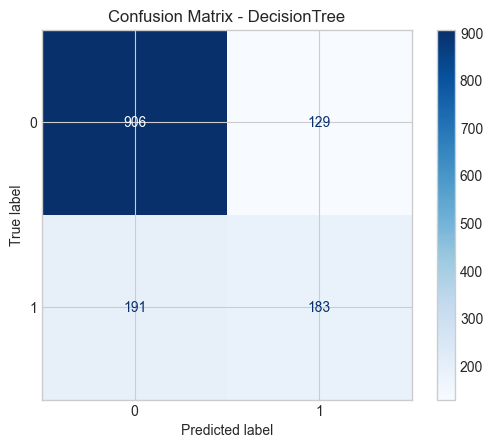


[2/3] Training Random Forest (this may take 1-2 minutes)...

=== RandomForest ===
Accuracy: 0.7942 | F1 (macro): 0.7100

Classification Report:
               precision    recall  f1-score   support

           0     0.8288    0.9072    0.8662      1035
           1     0.6522    0.4813    0.5538       374

    accuracy                         0.7942      1409
   macro avg     0.7405    0.6943    0.7100      1409
weighted avg     0.7819    0.7942    0.7833      1409



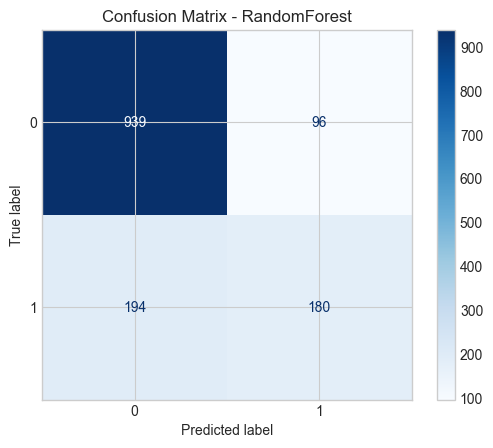


[3/3] Skipping SVM (set RUN_SVM = True to include)

Training complete! Summary:


,Model,Accuracy,F1_macro
0,RandomForest,0.794180,0.710041
1,DecisionTree,0.772889,0.691717


In [8]:
# Train and evaluate DT and RF (+ optional SVM)
results = []

# Optional SVM: set RUN_SVM = False to skip (SVM can be slow)
RUN_SVM = False  # Set to True to include SVM, but it may take several minutes

print("Starting model training...\n")

# Decision Tree (fast)
print("[1/3] Training Decision Tree...")
res_dt = evaluate_model('DecisionTree', models['DecisionTree'], X_train, y_train, X_test, y_test)
results.append(res_dt)

# Random Forest (moderate speed)
print("\n[2/3] Training Random Forest (this may take 1-2 minutes)...")
res_rf = evaluate_model('RandomForest', models['RandomForest'], X_train, y_train, X_test, y_test)
results.append(res_rf)

# Optional SVM
if RUN_SVM:
    print("\n[3/3] Training SVM (this may take several minutes - be patient)...")
    res_svm = evaluate_model('SVM (optional)', models['SVM (optional)'], X_train, y_train, X_test, y_test)
    results.append(res_svm)
else:
    print("\n[3/3] Skipping SVM (set RUN_SVM = True to include)")

print("\n" + "="*60)
print("Training complete! Summary:")
print("="*60)

metrics_df = pd.DataFrame([{ 'Model': r['model_name'], 'Accuracy': r['accuracy'], 'F1_macro': r['f1_macro'] } for r in results])
metrics_df_sorted = metrics_df.sort_values(by='F1_macro', ascending=False).reset_index(drop=True)
metrics_df_sorted



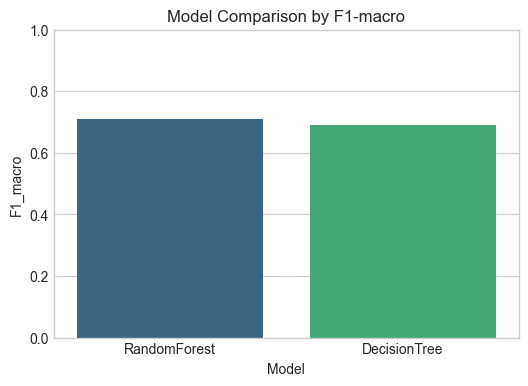

,Model,Accuracy,F1_macro
0,DecisionTree,0.772889,0.691717
1,RandomForest,0.794180,0.710041


In [9]:
# Compare performance & visualize
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=metrics_df.sort_values('F1_macro', ascending=False),
    x='Model', y='F1_macro', ax=ax, palette='viridis'
)
plt.title('Model Comparison by F1-macro')
plt.ylim(0, 1)
plt.show()

metrics_df.to_csv('artifacts/metrics_summary.csv', index=False)
metrics_df



In [10]:
# Persist best model
best = max(results, key=lambda r: r['f1_macro'])
print(f"Best by F1-macro: {best['model_name']} | F1={best['f1_macro']:.4f}")

best_model_path = f"models/{best['model_name'].replace(' ', '_').lower()}_pipeline.joblib"
joblib.dump(best['model'], best_model_path)
print(f"Saved: {best_model_path}")



Best by F1-macro: RandomForest | F1=0.7100
Saved: models/randomforest_pipeline.joblib
